# Notebook Setup

In [1]:
import numpy as np
import pandas as pd
from itertools import chain, combinations

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [2]:
sns.set()
sns.set_style("ticks")
sns.set_palette("colorblind")
sns.set_context("notebook")

# Pre-process the data

In [62]:
standardize = lambda x: (x - x.mean()) / x.std()

def preprocess(d: pd.DataFrame) -> pd.DataFrame:
    data = d.copy()
    
    # Fix invalid values
    data = data.replace(to_replace="?", value=np.nan)
    data = data.apply(pd.to_numeric)
    
    # Binarize classification
    data["num"] = data["num"].transform(lambda x: int(x > 0))
    
    # One-hot encode
    data["cp"] = data["cp"].astype("category")
    data["restecg"] = data["restecg"].astype("category")
    data["thal"] = data["thal"].astype("category")
    data = pd.get_dummies(data, prefix=["cp", "restecg", "thal"])
    
    # Move target to last column
    num = data["num"]
    data.drop(labels=["num"], axis=1 ,inplace=True)
    data.insert(data.shape[1], "num", num)
    
    # Standardize
    data["age"] = standardize(data["age"])
    data["trestbps"] = standardize(data["trestbps"])
    data["chol"] = standardize(data["chol"])
    data["thalach"] = standardize(data["thalach"])
    data["oldpeak"] = standardize(data["oldpeak"])
    data["slope"] = standardize(data["slope"])
    data["ca"] = standardize(data["ca"])
    
    return data

# Load Data

In [70]:
data = pd.read_csv("./data/cleveland.csv")
data = preprocess(data)

print("--- Columns ---")
print(" | ".join(list(data.columns.to_numpy().flatten())))
print()

print("--- Head ---")
display(data.head(3))
print()

print("--- Tail ---")
display(data.tail(3))
print()

print("--- Bad Rows ---")
display(data[data.isnull().any(axis=1)])

--- Columns ---
age | sex | trestbps | chol | fbs | thalach | exang | oldpeak | slope | ca | cp_1.0 | cp_2.0 | cp_3.0 | cp_4.0 | restecg_0.0 | restecg_1.0 | restecg_2.0 | thal_3.0 | thal_6.0 | thal_7.0 | num

--- Head ---


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,...,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,thal_3.0,thal_6.0,thal_7.0,num
0,0.947160,1.0,0.756274,-0.264463,1.0,0.017169,0.0,1.085542,2.270822,-0.717104,...,0,0,0,0,0,1,0,1,0,0
1,1.389703,1.0,1.608559,0.759159,0.0,-1.818896,1.0,0.396526,0.648041,2.483107,...,0,0,1,0,0,1,1,0,0,1
2,1.389703,1.0,-0.664201,-0.341717,0.0,-0.900864,1.0,1.343924,0.648041,1.416370,...,0,0,1,0,0,1,0,0,1,1



--- Tail ---


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,...,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,thal_3.0,thal_6.0,thal_7.0,num
300,0.283345,1.0,-0.096011,-2.234453,0.0,-1.512885,1.0,0.138144,0.648041,0.349633,...,0,0,1,1,0,0,0,0,1,1
301,0.283345,0.0,-0.096011,-0.206522,0.0,1.066349,0.0,-0.895381,0.648041,0.349633,...,1,0,0,0,0,1,1,0,0,1
302,-1.818736,1.0,0.358541,-1.384653,0.0,1.022633,0.0,-0.895381,-0.974740,NaN,...,0,1,0,1,0,0,1,0,0,0



--- Bad Rows ---


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,...,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,thal_3.0,thal_6.0,thal_7.0,num
166,-0.269835,1.0,0.358541,-0.457599,0.0,0.847770,0.0,-0.895381,-0.974740,NaN,...,0,1,0,1,0,0,1,0,0,0
192,-1.265557,1.0,0.017627,0.005928,1.0,-0.288842,1.0,-0.809253,0.648041,NaN,...,0,0,1,0,0,1,0,0,1,1
287,0.393980,1.0,-0.380106,-0.515540,0.0,-0.245126,0.0,-0.550872,0.648041,NaN,...,1,0,0,1,0,0,0,0,1,0
302,-1.818736,1.0,0.358541,-1.384653,0.0,1.022633,0.0,-0.895381,-0.974740,NaN,...,0,1,0,1,0,0,1,0,0,0


# KNN

In [5]:
def point_distance(point1: np.ndarray, point2: np.ndarray) -> float:
    """
    Computes the Euclidean distance between two sets of points.
    """

    return np.linalg.norm(point1 - point2)


def knn(train: pd.DataFrame, test: pd.DataFrame, k: int) -> float:
    """
    Finds the median class from k-nearest neighbors.
    """

    predictions = []
    
    for _, point1 in test.iterrows():
        distances = []
        point1 = point1.values

        for _, point2 in train.iterrows():
            point2 = point2.values
            distances.append([point2[-1], point_distance(point1[:-1], point2[:-1])])

        distances = sorted(distances, key=lambda pair: pair[1])

        vote = np.median(distances[:k], axis=0)[0]
        predictions.append(vote)

    return np.array(predictions)


def knn_cross_validation(data: pd.DataFrame, k: int, n: int) -> float:
    """
    Applies a k-nn classifier to the input data using n-fold
    cross validation and returns relevant error metrics.
    """

    df = data.copy()
    df = df.sample(frac=1)  # shuffles the data
    size = len(df) // n

    accuracy = np.zeros(n)
    precision = np.zeros(n)
    recall = np.zeros(n)
    f1 = np.zeros(n)
    
    for x in range(n):
        train = df.iloc[np.r_[0 : x * size, (x + 1) * size : 100]]
        test = df.iloc[x * size : (x + 1) * size]
        
        predictions = knn(train, test, k)
        test = test["num"].values.astype("float")
        
        accuracy[x] = accuracy_score(test, predictions)
        precision[x] = precision_score(test, predictions)
        recall[x] = recall_score(test, predictions)
        f1[x] = f1_score(test, predictions)
        
    return np.mean(accuracy), np.mean(precision), np.mean(recall), np.mean(f1)

def knn_leave_one_out_cross_validation(data: pd.DataFrame, k: int) -> float:
    """
    Applies a k-nn classifier to the input data using leave-one-out
    cross validation and returns relevant error metrics.
    """

    df = data.copy()
    size = 1
    
    predictions = []
    tests = []
    
    for x in range(len(df)):
        train = df.iloc[np.r_[0 : x * size, (x + 1) * size : 100]]
        test = df.iloc[x * size : (x + 1) * size]
        
        prediction = knn(train, test, k)
        test = test["num"].values.astype("float")
        
        predictions.append(prediction)
        tests.append(test)
        
    accuracy = accuracy_score(tests, predictions)
    precision = precision_score(tests, predictions)
    recall = recall_score(tests, predictions)
    f1 = f1_score(tests, predictions)
        
    return accuracy, precision, recall, f1

In [6]:
df = data.copy()
# df.drop(labels=["cp_1.0"], axis=1 ,inplace=True)
df.dropna()

accuracy, precision, recall, f1 = knn_leave_one_out_cross_validation(df, k=5)

print(f"Accuracy: {accuracy:7.4f}\nPrecision: {precision:6.4f}\nRecall: {recall:9.4f}\nf1: {f1:13.4f}")

Accuracy:  0.8185
Precision: 0.8333
Recall:    0.7554
f1:        0.7925


# Grid search features

In [7]:
attribute_group1 = [
    "age",
    "sex"
]
attribute_group2 = [
    "cp_1.0",
    "cp_2.0",
    "cp_3.0",
    "cp_4.0"
]
attribute_group3 = [
    "trestbps",
    "chol",
    "fbs",
    "restecg_0.0",
    "restecg_1.0",
    "restecg_2.0"
]
attribute_group4 = [
    "thalach",
    "exang",
    "oldpeak",
    "slope"
]
attribute_group5 = [
    "ca",
    "thal_3.0",
    "thal_6.0",
    "thal_7.0"
]
k_group = [3, 5, 7, 9]

# Grid search

In [8]:
def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

def grid_search_k(ks: list, data: pd.DataFrame) -> tuple:
    """
    Searches all combinations of the k's
    and returns the best performing k.
    """
    
    scores = []
    
    for k in ks:
        
        df = data.copy()
        df.dropna()
        _, _, _, f1 = knn_leave_one_out_cross_validation(df, k=k)
        scores.append([k, f1])
        
        print(f"k = {k} | f1 = {f1:4f}")

    scores = sorted(scores, key=lambda pair: -pair[1])
    
    return scores[0]

def grid_search_attributes(attribute_group: list, k: int, data: pd.DataFrame) -> tuple:
    """
    Searches all combinations of the attribute group
    and returns the best performing grouping.
    """
    
    permutations = powerset(attribute_group)
    scores = []
    
    for permutation in permutations:
        
        df = data.copy()
        df.drop(labels=list(permutation), axis=1, inplace=True)
        df.dropna()

        _, _, _, f1 = knn_leave_one_out_cross_validation(df, k=k)
        scores.append([permutation, f1])
        
        print(f"Dropped {permutation} and got f1 = {f1:4f}.")

    scores = sorted(scores, key=lambda pair: -pair[1])
    
    return scores[0]

def full_grid_search(attribute_group: list, ks: list, data: pd.DataFrame) -> tuple:
    """
    Performs a grid search with attributes and k-values.
    Returns the best performing group.
    """
    
    permutations = powerset(attribute_group)
    scores = []
    
    with open("log.csv", "w+") as fout:
        fout.write("dropped_attributes,k,f1\n")
    
    for permutation in permutations:
        for k in ks:
            
            df = data.copy()
            df.drop(labels=list(permutation), axis=1, inplace=True)
            df.dropna()

            _, _, _, f1 = knn_leave_one_out_cross_validation(df, k=k)
            scores.append([(permutation, k), f1])

            with open("log.csv", "a+") as fout:
                fout.write(f'"{permutation}",{k},{f1}\n')
            
    scores = sorted(scores, key=lambda pair: -pair[1])
    
    return scores[0]

In [9]:
# grid_search_k(k_group, data)

In [10]:
# k = 5
# grid_search_attributes(attribute_group1, k, data)

In [11]:
# # data.drop(inplace=True)  nothing to drop
# grid_search_attributes(attribute_group2, k, data)

In [12]:
# # data.drop(labels=["cp_3.0"], axis=1 ,inplace=True)
# grid_search_attributes(attribute_group3, k, data)

In [13]:
# # data.drop(labels=["trestbps", "fbs", "restecg_0.0", "restecg_2.0"], axis=1, inplace=True)
# grid_search_attributes(attribute_group4, k, data)

In [14]:
# # data.drop(labels=["thalach", "oldpeak", "slope"], axis=1, inplace=True)
# grid_search_attributes(attribute_group5, k, data)

In [15]:
# # data.drop(labels=[], axis=1, inplace=True)
# grid_search_k(k_group, data)

In [16]:
all_attributes = attribute_group1 + attribute_group2 + attribute_group3 + attribute_group4
full_grid_search(all_attributes, k_group, data)

KeyboardInterrupt: 

In [19]:
attributes = pd.read_csv("log.csv")
attributes

,dropped_attributes,k,f1
0,(),3,0.798587
1,(),5,0.792453
2,(),7,0.781609
3,(),9,0.786260
4,"('age',)",3,0.781362
...,...,...,...
58474,"('cp_4.0', 'chol', 'restecg_1.0', 'thalach', '...",7,0.774908
58475,"('cp_4.0', 'chol', 'restecg_1.0', 'thalach', '...",9,0.772059
58476,"('cp_4.0', 'chol', 'restecg_1.0', 'thalach', '...",3,0.759124
58477,"('cp_4.0', 'chol', 'restecg_1.0', 'thalach', '...",5,0.772059


In [98]:
best_5 = attributes.sort_values("f1", ascending=False).head(3)
worst_5 = attributes.sort_values("f1", ascending=True).head(3)

display(best_5)
display(worst_5)

best_5.to_csv("temp.csv")

,dropped_attributes,k,f1
36006,"('age', 'cp_2.0', 'chol', 'restecg_0.0', 'thal...",7,0.845588
31167,"('age', 'sex', 'chol', 'restecg_0.0', 'thalach...",9,0.845588
36070,"('age', 'cp_2.0', 'chol', 'restecg_2.0', 'thal...",7,0.845588


,dropped_attributes,k,f1
56713,"('cp_3.0', 'cp_4.0', 'thalach', 'exang', 'oldp...",5,0.698885
56715,"('cp_3.0', 'cp_4.0', 'thalach', 'exang', 'oldp...",9,0.701887
56712,"('cp_3.0', 'cp_4.0', 'thalach', 'exang', 'oldp...",3,0.708029


# Get testing data

In [84]:
def format_data(data):
    data = preprocess(data)
    data = data.drop(labels=["age", "restecg_0.0", "chol", "thalach", "oldpeak", "cp_2.0"], axis=1)  # k = 7
#     data = data.drop(labels=["age", "sex", "chol", "thalach", "oldpeak", "cp_2.0"], axis=1)  # k = 9
    return data, 7

In [85]:
data = pd.read_csv("./data/cleveland.csv")
data, k = format_data(data)

print("LOOV")
accuracy, precision, recall, f1 = knn_leave_one_out_cross_validation(data, k=k)
print(f"Accuracy: {accuracy:7.4f}\nPrecision: {precision:6.4f}\nRecall: {recall:9.4f}\nf1: {f1:13.4f}")

print("\n10-fold")
accuracy, precision, recall, f1 = knn_cross_validation(data, k=k, n=10)
print(f"Accuracy: {accuracy:7.4f}\nPrecision: {precision:6.4f}\nRecall: {recall:9.4f}\nf1: {f1:13.4f}")

LOOV
Accuracy:  0.8614
Precision: 0.8647
Recall:    0.8273
f1:        0.8456

10-fold
Accuracy:  0.8300
Precision: 0.8627
Recall:    0.7697
f1:        0.8074


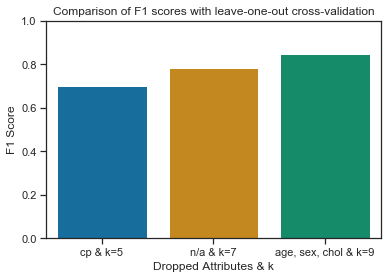

In [95]:
x = ["cp & k=5", "n/a & k=7", "age, sex, chol & k=9"]
y = [0.698885,0.7816,0.845588]

sns.barplot(x, y)
plt.ylim([0,1])
plt.xlabel("Dropped Attributes & k")
plt.ylabel("F1 Score")
plt.title("Comparison of F1 scores with leave-one-out cross-validation")
plt.show()